<a href="https://colab.research.google.com/github/jidan-fikri/AWAN-App/blob/master/Awan_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the library

In [1]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
import zipfile
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import sklearn
import itertools
from sklearn.metrics import classification_report, confusion_matrix

## Prepare the dataset

In [2]:
!gdown 19imo6OOAhRXqgfH2NMHYu3OwxQ5HEA3I
with zipfile.ZipFile('cloudv3.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cloud-classifier')

Downloading...
From: https://drive.google.com/uc?id=19imo6OOAhRXqgfH2NMHYu3OwxQ5HEA3I
To: /content/cloudv3.zip
100% 95.1M/95.1M [00:03<00:00, 29.2MB/s]


In [ ]:
base_dir = '/content/cloud-classifier'
train_dir = os.path.join(base_dir, 'train')

In [ ]:
BATCH_SIZE = 8
IMAGE_SIZE = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2336 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['Heavy_Rain', 'Low_Chance_of_Rain', 'Medium_Rain']

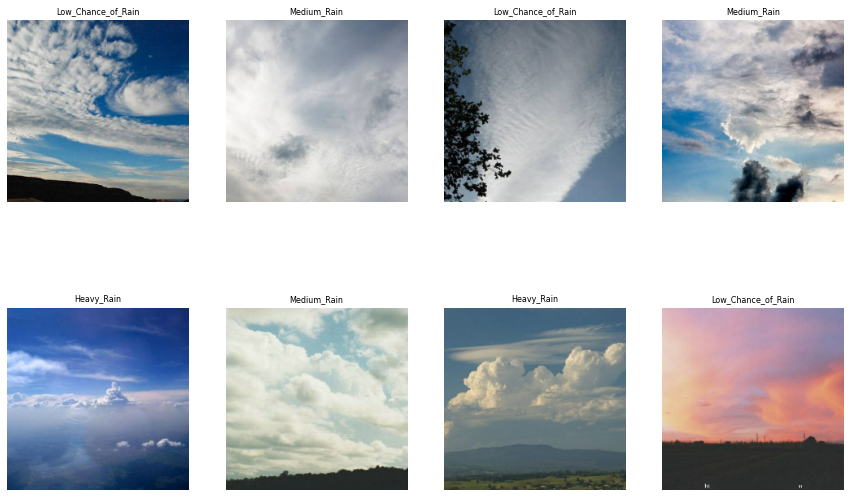

In [ ]:
 plt.figure(figsize = (15,15))
 for image_batch, label_batch in train_dataset.take(1):
   for i in range(8):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]],fontsize = 8)
     plt.axis("off")
  #  print(image_batch.shape[0].shape)

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.1, test_split = 0.1,shuffle = True,shuffle_size = 10000):
  assert(train_split+val_split+test_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 8)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  test_size = int(test_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).take(test_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(train_dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Setting up dataset and transfer learning for model training

In [ ]:
data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
    classes=3,
    classifier_activation="softmax",
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model = models.Sequential([
  base_model,
  layers.Conv2D(64, (3, 3), activation = 'relu'),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling2D(), 
  layers.Dense(3, activation='softmax'),
])
model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 3, 3, 64)          1179712   
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 22,982,691
Trainable params: 22,948,259
Non-trainable params: 34,432
_____________________________________

## Training and evaluating model 

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
filepath = "/content/cloud.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds_ds,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose = 1,
)

Epoch 1/30
233/233 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.5848
Epoch 1: val_accuracy improved from -inf to 0.56466, saving model to /content/cloud.h5
233/233 [==============================] - 37s 82ms/step - loss: 0.8861 - accuracy: 0.5848 - val_loss: 0.8857 - val_accuracy: 0.5647
Epoch 2/30
233/233 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.6845
Epoch 2: val_accuracy improved from 0.56466 to 0.61207, saving model to /content/cloud.h5
233/233 [==============================] - 16s 69ms/step - loss: 0.7270 - accuracy: 0.6845 - val_loss: 0.8401 - val_accuracy: 0.6121
Epoch 3/30
233/233 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.7178
Epoch 3: val_accuracy improved from 0.61207 to 0.71983, saving model to /content/cloud.h5
233/233 [==============================] - 16s 70ms/step - loss: 0.6568 - accuracy: 0.7178 - val_loss: 0.7047 - val_accuracy: 0.7198
Epoch 4/30
233/233 [==========================

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

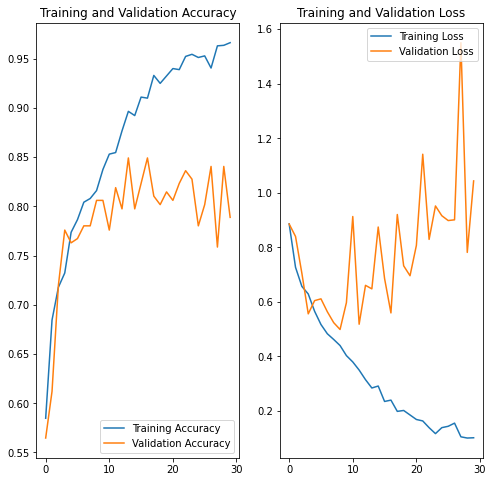

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model testing with test set

In [ ]:
model = load_model("/content/cloud.h5")


In [ ]:
scores = model.evaluate(test_ds)

29/29 [==============================] - 2s 28ms/step - loss: 0.3681 - accuracy: 0.8534


first image to predict
actual label: Medium_Rain
predicted label: Medium_Rain


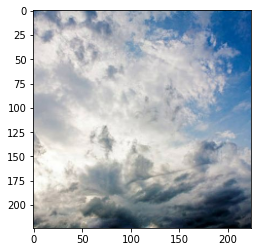

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

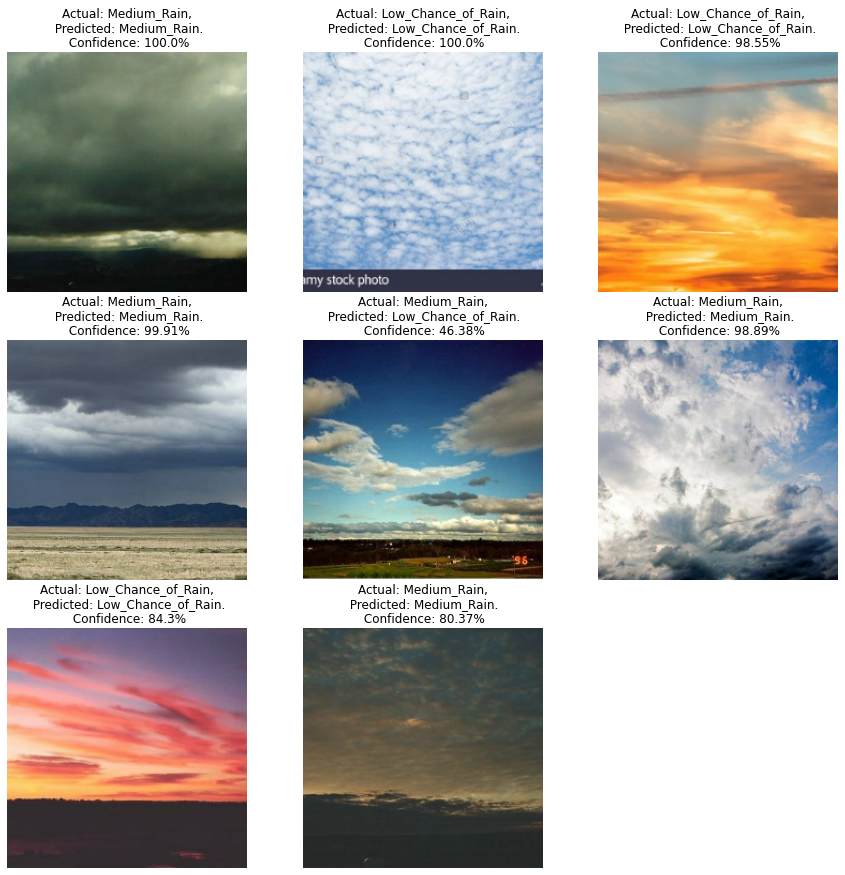

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

                    precision    recall  f1-score   support

        Heavy_Rain       0.66      0.81      0.72        31
Low_Chance_of_Rain       0.89      0.90      0.89       107
       Medium_Rain       0.90      0.82      0.86        94

          accuracy                           0.85       232
         macro avg       0.81      0.84      0.82       232
      weighted avg       0.86      0.85      0.86       232

Confusion matrix, without normalization
[[25  6  7]
 [ 2 96 10]
 [ 4  5 77]]


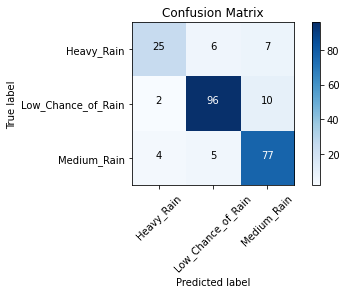

In [ ]:
y_pred = model.predict(test_ds)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)

target_names = class_names
print(sklearn.metrics.classification_report(true_categories, predicted_categories, target_names=target_names))


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = target_names
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Convert model to tflite files

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 40 kB 6.7 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
SAVED_MODEL = "cloud_saved_model"
tf.saved_model.save(model, SAVED_MODEL)

INFO:tensorflow:Assets written to: cloud_saved_model/assets


INFO:tensorflow:Assets written to: cloud_saved_model/assets


In [ ]:
tflite_model = tf.keras.models.load_model("/content/cloud.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_save = converter.convert()
open("/content/cloud.tflite", "wb").write(tflite_save)

INFO:tensorflow:Assets written to: /tmp/tmpghljlnd1/assets


23415648

In [ ]:
!mkdir json_model

In [ ]:
!tensorflowjs_converter --input_format=keras {"cloud.h5"} ./

In [ ]:
!mv *.bin *.json json_model/

In [ ]:
!zip -r /content/json_model.zip /content/json_model

  adding: content/json_model/ (stored 0%)
  adding: content/json_model/group1-shard12of22.bin (deflated 7%)
  adding: content/json_model/group1-shard1of22.bin (deflated 8%)
  adding: content/json_model/group1-shard16of22.bin (deflated 7%)
  adding: content/json_model/group1-shard10of22.bin (deflated 7%)
  adding: content/json_model/group1-shard2of22.bin (deflated 7%)
  adding: content/json_model/model.json (deflated 96%)
  adding: content/json_model/group1-shard14of22.bin (deflated 7%)
  adding: content/json_model/group1-shard5of22.bin (deflated 7%)
  adding: content/json_model/group1-shard7of22.bin (deflated 7%)
  adding: content/json_model/group1-shard17of22.bin (deflated 7%)
  adding: content/json_model/group1-shard18of22.bin (deflated 7%)
  adding: content/json_model/group1-shard13of22.bin (deflated 7%)
  adding: content/json_model/group1-shard22of22.bin (deflated 7%)
  adding: content/json_model/group1-shard6of22.bin (deflated 7%)
  adding: content/json_model/group1-shard21of22.bi

In [ ]:
!zip -r /content/saved_model.zip /content/cloud_saved_model

  adding: content/cloud_saved_model/ (stored 0%)
  adding: content/cloud_saved_model/saved_model.pb (deflated 92%)
  adding: content/cloud_saved_model/assets/ (stored 0%)
  adding: content/cloud_saved_model/variables/ (stored 0%)
  adding: content/cloud_saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/cloud_saved_model/variables/variables.index (deflated 79%)


In [ ]:
from google.colab import files
files.download("/content/cloud.h5")
files.download("/content/cloud.tflite")
files.download("/content/requirements.txt")
files.download("/content/json_model.zip")
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>